<div align="right">Python 3.6 Jupyter Notebook</div>

# Finding connected components using  clustering

### Your completion of the notebook exercises will be graded based on your ability to do the following:

> **Understand**: Do your pseudo-code and comments show evidence that you recall and understand technical concepts?

> **Apply**: Are you able to execute code (using the supplied examples) that performs the required functionality on supplied or generated data sets? 

> **Analyze**: Are you able to pick the relevant method or  library to resolve specific stated questions?

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?

#### Notebook objectives
By the end of this notebook, you will be expected to:
> 
  - Find connected components in networks (using the techniques of **`hierarchical clustering`**, **`modularity maximization`**, and **`spectral graph partitioning`**); and
  - Interpret clustering results.
  
####  List of exercises
> - **Exercise 1**: Understanding hierarchical clustering.
- **Exercise 2 [Advanced]**: Interpreting the results of hierarchical clustering.
- **Exercise 3 [Advanced]**: Summarizing clustering results based on modularity maximization and spectral graph partitioning.

# Notebook introduction

Community detection is an important task in social network analysis. The idea behind it is to identify groups of people that share a common interest, based on the assumption that these people tend to link to each other more than to the rest of the network. Specifically, real-world networks exhibit clustering behavior that can be observed in the graph representation of these networks by the formation of clusters or partitions. These groups of nodes on a graph (clusters) correspond to communities that share common properties, or have a common role in the system under study.

Intuitively, it is expected that such clusters are associated with a high concentration of nodes. In the following examples, you will explore the identification of these clusters using the following approaches, as discussed in the video content:

- **`Hierarchical clustering`** (using a distance matrix)
- The **`Louvain Algorithm`** (using **`modularity maximization`**)
- **`Spectral graph partitioning`**

#### Import required modules

In [2]:
import networkx as nx
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout

from collections import defaultdict, Counter
import operator

## For hierarchical clustering.
from scipy.cluster import hierarchy
from scipy.spatial import distance

## For spectral graph partitioning.
from sklearn.cluster import spectral_clustering as spc

## For Community Detection (Louvain Method).
import community


import sys
sys.path.append('..')
from utils import draw_partitioned_graph
from utils import fancy_dendrogram

plt.rcParams['figure.figsize'] = (15, 9)
plt.rcParams['axes.titlesize'] = 'large'

ImportError: cannot import name 'draw_partitioned_graph' from 'utils' (c:\Users\Pathways\anaconda3\Lib\site-packages\utils\__init__.py)

## 1. Data preparation

You are going to read the graph from an adjacency list saved in earlier exercises.

In [5]:
call_adjmatrix = pd.read_csv('./call.adjmatrix', index_col=0)
call_graph = nx.from_numpy_array(call_adjmatrix.values)

In [6]:
call_adjmatrix.shape

(129, 129)

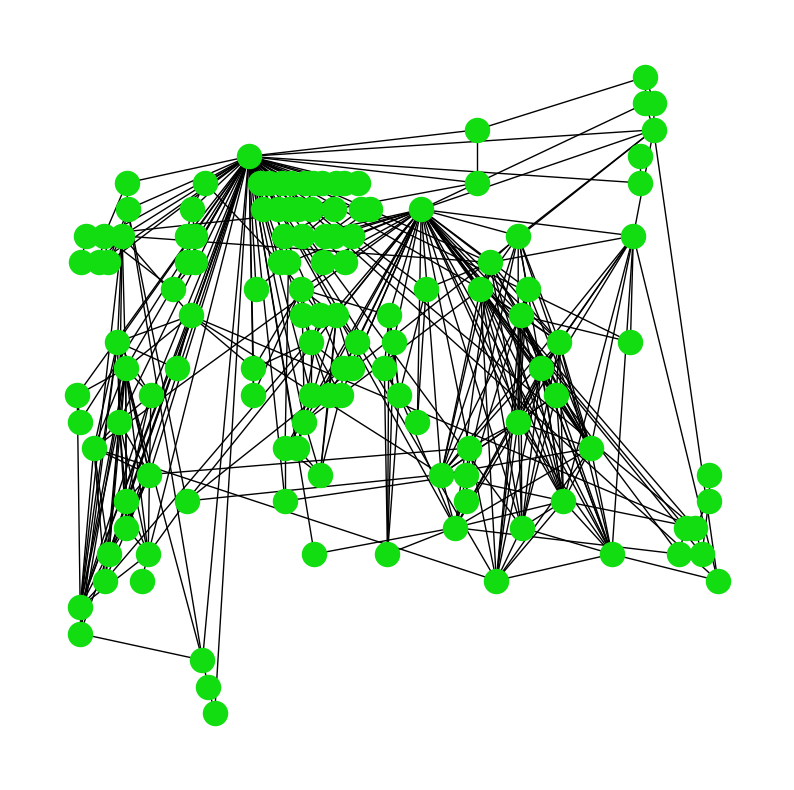

In [7]:
# Display call graph object.
plt.figure(figsize=(10,10))
plt.axis('off')

pos = graphviz_layout(call_graph, prog='dot')
nx.draw_networkx(call_graph, pos=pos, node_color='#11DD11', with_labels=False)
_ = plt.axis('off')

## 2. Hierarchical clustering

Hierarchical clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. It is widely used in data analysis to group similar objects into clusters based on a set of observed characteristics. There are two main types of hierarchical clustering:

### 1. Agglomerative (Bottom-Up Approach)
This is the most common type of hierarchical clustering used to group objects in clusters based on their similarity. It's also known as the bottom-up approach because it starts with each object as a separate cluster and then successively merges clusters until all objects are in one cluster or until a desired structure is achieved. The steps include:

- **Initial Step:** Treat each data point as a single cluster. Hence, there are as many clusters as there are data points.
- **Merge Step:** Find the two clusters that are closest together and merge them into a single cluster.
- **Repeat Step:** Repeat the merging process until all the data points are merged into a single cluster or until the desired number of clusters is reached.

The result of agglomerative clustering can be visualized using a **`dendrogram`**, a tree-like diagram that shows the arrangement of the clusters produced by the corresponding analyses.

### 2. Divisive (Top-Down Approach)
This is a less common approach that works in the opposite way to agglomerative clustering. It is also known as the top-down approach. Here’s how it works:

- **Initial Step:** Start with all data points in a single cluster.
- **Split Step:** Split the cluster into two least similar clusters.
- **Repeat Step:** Continue splitting the clusters recursively until each cluster only contains one data point or until the desired number of clusters is achieved.

### Key Components in Hierarchical Clustering
- **Distance Metric:** This is a measure used to determine the similarity (or dissimilarity) between two data points or clusters. Common metrics include Euclidean distance, Manhattan distance, and Cosine similarity.
- **Linkage Criteria:** This determines how the distance between clusters is measured. In agglomerative clustering, common linkage criteria include:
  - **Single Linkage:** Distance between the closest members of two clusters.
  - **Complete Linkage:** Distance between the farthest members of two clusters.
  - **Average Linkage:** Average distance between all members of two clusters.
  - **Ward’s Method:** Minimizes the variance within each cluster.

### Applications
Hierarchical clustering is used in various fields such as:

- **Biology:** For constructing phylogenetic trees.
- **Information Retrieval:** For organizing and summarizing large sets of unstructured data, like grouping news articles or research papers.
- **Social Networking:** For community detection within social networks.
- **Market Research:** For customer segmentation.

### Advantages and Disadvantages
- **Advantages:** No need to specify the number of clusters in advance, provides an additional insight into the data via dendrograms.
- **Disadvantages:** Computationally intensive for large datasets, sensitive to noise and outliers.

In practice, the choice between agglomerative and divisive methods, as well as the selection of distance metrics and linkage criteria, largely depends on the nature of the data and the specific requirements of the analysis.

This notebook makes use of a hierarchical clustering algorithm, as implemented in [Scipy](http://docs.scipy.org/doc/scipy/reference/). The following example uses the average distance measure. Since the graph is weighted, you can also use the single linkage inter-cluster distance measure (see exercises).

In [8]:
def create_hc(G, linkage='average'):
    """
    Creates hierarchical cluster of graph G from distance matrix
    """ 
    
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((G.order(),G.order())) 
    
    for u,p in dict(path_length).items():
        for v,d in p.items():
            distances[list(G.nodes)[u]][list(G.nodes)[v]] = d
            distances[list(G.nodes)[v]][list(G.nodes)[u]] = d
            if u==v: 
                distances[list(G.nodes)[u]][list(G.nodes)[u]]=0
    # Create hierarchical cluster (HC).
    Y=distance.squareform(distances)
    if linkage == 'max':
        # Creates HC using farthest point linkage.
        Z=hierarchy.complete(Y)  
    if linkage == 'single':
        # Creates HC using closest point linkage.
        Z=hierarchy.single(Y)  
    if linkage == 'average':
        # Creates HC using average point linkage.
        Z=hierarchy.average(Y)
        
    return Z

def get_cluster_membership(Z, maxclust):
    '''
    Assigns cluster membership by specifying cluster size.
    '''
    # Create list where each element is the cluster label for the corresponding observation in our original data
    hc_out=list(hierarchy.fcluster(Z,maxclust, criterion='maxclust'))
    
    # Map cluster values to a dictionary variable.
    cluster_membership = {}
    i = 0
    for i in range(len(hc_out)):
        cluster_membership[i]=hc_out[i]
    
    return cluster_membership

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
 
    ddata = hierarchy.dendrogram(*args, **kwargs)
 
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

Below is a demonstration of hierarchical clustering when applied to the call graph.

In [9]:
# Perform hierarchical clustering using 'average' linkage. 
Z = create_hc(call_graph, linkage='average') 

The dendrogram corresponding to the partitioned graph is obtained as follows:

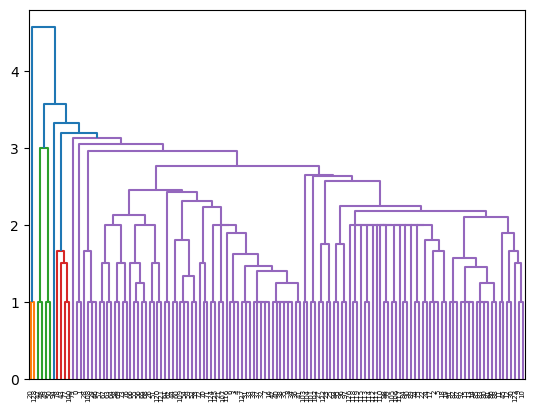

In [10]:
hierarchy.dendrogram(Z)
plt.show()

You will notice that the full dendrogram is unwieldy, and difficult to use or read. Fortunately, the `dendrogram` method has a feature that allows one to only show the `lastp` merged clusters, where $p$ is the desired number of last `p` merged clusters.

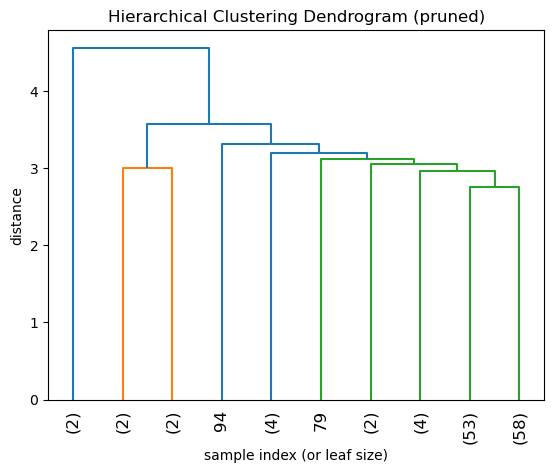

In [11]:
plt.title('Hierarchical Clustering Dendrogram (pruned)')
plt.xlabel('sample index (or leaf size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,                   # show only the last p merged clusters
    show_leaf_counts=True,  # numbers in brackets are counts for each leaf
    leaf_rotation=90,
    leaf_font_size=12)
plt.show()

This dendrogram can help explain what happens as a result of the agglomerative method of hierarchical clustering. Starting at the bottom-most level, each node is assigned its own cluster. The closest pair of nodes (according to a distance function) are then merged into a new cluster. The distance matrix is recomputed, treating the merged cluster as an individual node. This process is repeated until the entire network has been merged into a single, large cluster, which the top level in the dendrogram above represents. You can now understand why this method is agglomerative.

The linkage function is used to determine the distance between a cluster and a node, or between two clusters, using the following possibilities:

- **Single:** Merge two clusters with the smallest minimum pairwise distance.
- **Average:** Merge two clusters with the smallest average pairwise distance.
- **Maximum or complete:** Merge the two clusters with the smallest maximum pairwise distance.

Now, you can finally retrieve the clusters, based on the analysis of the dendrogram. In this post-processing, there are different ways of determining $k$, the number of clusters to partition the data into. Scipy's hierarchical flat clustering function - "``hierarchy.fcluster()``" - is used to assign cluster membership by specifying a distance threshold, or the number of clusters required. In the function definition (above), you have been provided with a utility function, "``get_cluster_membership()``", which does the latter.

Selecting the number of clusters $k$ is, in general, an ill-posed problem. Different interpretations are possible, depending on the nature of the problem, the scale of the distribution of points in a data set, and the required clustering resolution. In agglomerative clustering, as used in the example above, you can get zero error for the objective function by considering each data point as its own cluster. Hence, the selection of $k$ invariably involves a trade-off maximum compression of the data (using a single cluster), and maximum accuracy by assigning each data point to its own cluster. The selection of an optimal $k$ can be done using automated techniques or manually.

Here, identification of an appropriate cluster is ideally done manually as this has the advantages of gaining some insights into your data as well as providing an opportunity to [perform sanity checks](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial). To select the cluster size, look for a large shift in the distance metric. In our example with dendrograms plots shown above, say a case has been made for an ideal cutoff of 3.5. The number of clusters is then simply the number of intersections of a horizontal line (with height of 3.5) with the vertical lines of the dendrogram. Therefore, 3 clusters would be obtained in this case as shown below.

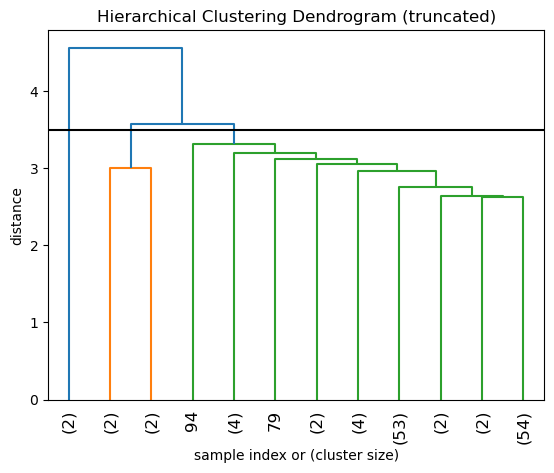

In [12]:
fancy_dendrogram( Z, truncate_mode='lastp', p=12, leaf_rotation=90.,
    leaf_font_size=12.0,
    show_contracted=False,
    annotate_above=10,
    max_d=3.5)
plt.show()

In [13]:
opt_clust = 3
opt_clust

3

You can now assign the data to these "``opt_clust``" clusters.

In [14]:
cluster_assignments = get_cluster_membership(Z, maxclust=opt_clust)

The partitioned graph, corresponding to the dendrogram above, can now be visualized.

In [15]:
clust = list(set(cluster_assignments.values()))
clust

[1, 2, 3]

In [16]:
cluster_centers = sorted(set(cluster_assignments.values()))
freq = [list(cluster_assignments.values()).count(x) for x in cluster_centers]

In [17]:
# Creata a DataFrame object containing list of cluster centers and number of objects in each cluster
df = pd.DataFrame({'cluster_centres':cluster_centers, 'number_of_objects':freq})
df.head()

,cluster_centres,number_of_objects
0,1,2
1,2,4
2,3,123


<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions

> 1. How many clusters are obtained after the final step of a generic agglomerative clustering algorithm (before post-processing)?
>> **Note:** Post-processing involves determining the optimal clusters for the problem at hand.
> 2. Based on your answer above, would you consider agglomerative clustering a top-down approach, or a bottom-up approach?
> 3. Which of the three linkage functions (i.e. single, average, or maximum or complete) do you think is likely to be most sensitive to outliers? 
>>**Hint**: Look at this [single-link and complete-link clustering](http://nlp.stanford.edu/IR-book/html/htmledition/single-link-and-complete-link-clustering-1.html) resource.

#### Exercise 1 answers 
1. After the final step 3 clusters are obtained.
2. Since agglomerative clustering starts at the bottom-most level by selecting a cut-off level of 3.5 with each node being assigned its own cluster, and the process is done iteratively until all nodes are clustered into one node, I would say it is a bottom-up approach.
3. According to https://nlp.stanford.edu/IR-book/html/htmledition/single-link-and-complete-link-clustering-1.html maximum or complete-linkage clustering is most likely to be sensistive to outliers. This is because when merging, similarity of two clusters is the similarity of their most dissimilar members.


<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>
> **Exercise complete**:

> This is a good time to "Save and Checkpoint".

## 3. Community detection
Community detection is an important component in the analysis of large and complex networks. Identifying these subgraph structures helps in understanding organizational and functional characteristics of the underlying physical networks. In this section, you will study a few  approaches that are widely used in community detection using graph representations.

### 3.1 The Louvain modularity-maximization approach

The Louvain method is one of the most widely-used methods for detecting communities in large networks. It was developed by a team of researchers at the Université catholique de Louvain. The method can unveil hierarchies of communities, and allows you to zoom within communities in order to discover sub-communities, sub-sub-communities, and so forth. The modularity $Q_c$ quantifies how good a "community" or partition is, and is defined as follows:

$$Q_c =\frac{1}{2m}\sum _{(ij)} \left [ A_{ij}-\frac{k_ik_j}{2m} \right] \delta(c_i, c_j)$$

The higher the $Q_c$ of a community is, the better the partition is.

The Louvain method is a greedy optimization method that attempts to optimize the "modularity" of a partition of the network via two steps:

1. Locally optimize the modularity to identify "small" communities.
2. Aggregate nodes belonging to the same community, and create a new network with aggregated nodes as individual nodes.

Steps 1 and 2 are then repeated until a maximum of modularity produces a hierarchy of communities.

C:\Users\Pathways\AppData\Local\Temp\ipykernel_20768\559302618.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', num_communities)  # Colormap based on the number of communities


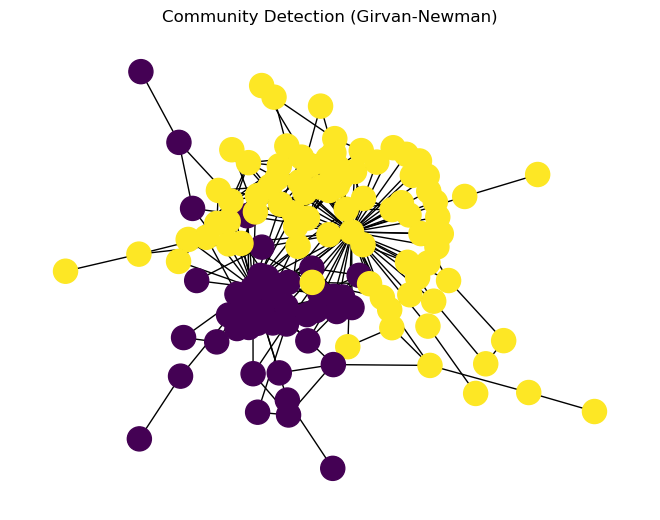

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

# Creating a synthetic graph (you can replace this with your own graph)
G = call_graph

# Apply Girvan-Newman algorithm for community detection
comp = nx.community.girvan_newman(G)
communities = next(comp)

# Choose the number of communities you want to visualize
num_communities = 4  # You can adjust this based on your preference

# Assign community labels to nodes
node_colors = {}
for i, community in enumerate(communities):
    if i < num_communities:
        for node in community:
            node_colors[node] = i

# Visualize the graph with communities
pos = nx.spring_layout(G)
node_colors = [node_colors.get(node, num_communities) for node in G.nodes()]  # Assign default color for unassigned nodes
cmap = plt.cm.get_cmap('viridis', num_communities)  # Colormap based on the number of communities

# Draw nodes with community colors
nx.draw(G, pos, node_color=node_colors, cmap=cmap, with_labels=False)
plt.title("Community Detection (Girvan-Newman)")
plt.show()


### 3.2 Spectral graph partitioning

Spectral graph partitioning and clustering is based on the spectrum — the eigenvalues and associated eigenvectors — of the Laplacian matrix that corresponds to a given graph. The approach is mathematically complex, but involves performing a $k$-means clustering, on a spectral projection of the graph, with $k$=2 (using an adjacency matrix as the affinity). A schematic illustration of the process is depicted in the figure below.

**Optional**: You can read more about [spectral graph processing](https://devblogs.nvidia.com/parallelforall/fast-spectral-graph-partitioning-gpus/).

<img src="img/spectral_graph_part.png" width=750, height=750>

Now, apply spectral graph partitioning to your call graph, and visualize the resulting community structure. You can read more about [Scikit-Learn](http://scikit-learn.org/stable/index.html), and the [Spectral Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) function utilized in this section. Spectral graph partitioning needs input in the form of the number of clusters sought (default setting is 8). There are various approaches one can take to optimize the final number of clusters, depending on problem domain knowledge. Below you will use a value of $k=9$.

In [18]:
# Create the spectral partition using the spectral clustering function from Scikit-Learn.
spectral_partition = spc(affinity=call_adjmatrix.values, n_clusters=9, assign_labels='discretize')

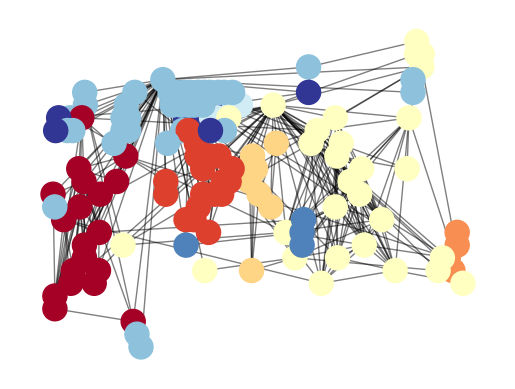

In [31]:
pos = graphviz_layout(call_graph, prog='dot')
nx.draw_networkx_nodes(call_graph, pos, cmap=plt.cm.RdYlBu, node_color=spectral_partition)
nx.draw_networkx_edges(call_graph, pos, alpha=0.5)
plt.axis('off')
plt.show()

The `spectral_partition` variable is a collection of cluster labels assigned to each data point in the dataset processed by the spectral clustering algorithm, where the number of clusters is set to 9, and the method of assigning these labels is based on discretization of the data points in the reduced-dimensional space.

The `spectral_partition` variable contains integers from 1 to 9, inclusive, representing the cluster each data point is assigned to.

In [28]:
print(spectral_partition)

[4 4 6 4 4 6 4 4 4 6 6 6 0 0 0 0 4 8 8 8 8 8 6 6 6 6 1 6 2 2 6 4 4 4 4 4 4
 4 4 4 4 4 4 7 3 4 2 5 5 5 5 3 3 3 3 1 1 1 1 4 3 4 6 1 1 1 1 1 1 1 1 1 6 1
 6 6 1 7 7 0 0 0 0 0 0 0 0 0 0 6 6 0 0 0 0 0 6 6 6 6 7 6 6 6 6 6 6 8 2 3 4
 6 6 6 6 6 4 4 6 6 1 1 6 6 4 4 6 4 8]


In [23]:
len(spectral_partition)

129